In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option("display.max_columns", 100)

DATA_PATH = Path.cwd() / "data" 

def load_data(DATA_PATH):
    features_df = pd.read_csv(
        DATA_PATH / "training_set_features.csv", 
        index_col="respondent_id"
    )
    labels_df = pd.read_csv(
        DATA_PATH / "training_set_labels.csv", 
        index_col="respondent_id"
    )
    return features_df, labels_df


def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

def performance_analysis(preds, y_eval):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

    plot_roc(
        y_eval['h1n1_vaccine'], 
        y_preds['h1n1_vaccine'], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    plot_roc(
        y_eval['seasonal_vaccine'], 
        y_preds['seasonal_vaccine'], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    return

features_df, label_df = load_data(DATA_PATH)

X_train, X_eval, y_train, y_eval = train_test_split(features_df, label_df, test_size = 0.2, random_state = 42)
y_train_h1n1 = y_train["h1n1_vaccine"]
y_train_sf = y_train["seasonal_vaccine"]
y_eval_h1n1 = y_eval["h1n1_vaccine"]
y_eval_sf = y_eval["seasonal_vaccine"]

num_pipeline = Pipeline([('std_scaler', StandardScaler()),('imputer', SimpleImputer(strategy = "median"))])
cat_pipeline = Pipeline([('Encoder',OneHotEncoder())])
num_attribs = features_df.columns[features_df.dtypes != "object"].values
cat_attribs = features_df.columns[features_df.dtypes == "object"].values

preprocessor = ColumnTransformer([("num", num_pipeline, num_attribs),
                                  ("cat", cat_pipeline, cat_attribs)], remainder = "drop")
X_train_prepared = preprocessor.fit_transform(X_train)

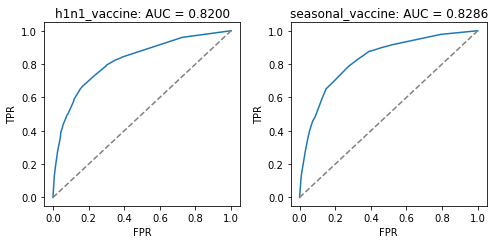

In [2]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
estimators = MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth = 5))

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[0][:, 1],
           "seasonal_vaccine": preds[1][:, 1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

In [3]:
import tensorflow as tf
from tensorflow import keras
y_train_ann = y_train.copy()
y_train_ann["no_h1n1_vaccine"] = 1 - y_train_ann["h1n1_vaccine"]
y_train_ann["no_seasonal_vaccine"] = 1 - y_train_ann["seasonal_vaccine"]
X_train_ann, X_valid , y_train_ann, y_valid = train_test_split(X_train_prepared,y_train_ann, random_state = 42, test_size = 0.1)
model = keras.models.Sequential()
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(4, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["AUC"])
history = model.fit(X_train_ann, y_train_ann, epochs = 30, validation_data = (X_valid, y_valid))

Epoch 1/30
601/601 [==============================] - 7s 9ms/step - loss: 0.5928 - auc: 0.7595 - val_loss: 0.5369 - val_auc: 0.8084
Epoch 2/30
601/601 [==============================] - 4s 7ms/step - loss: 0.4999 - auc: 0.8408 - val_loss: 0.4781 - val_auc: 0.8538
Epoch 3/30
601/601 [==============================] - 4s 7ms/step - loss: 0.4671 - auc: 0.8614 - val_loss: 0.4613 - val_auc: 0.8644
Epoch 4/30
601/601 [==============================] - 4s 7ms/step - loss: 0.4548 - auc: 0.8688 - val_loss: 0.4524 - val_auc: 0.8700
Epoch 5/30
601/601 [==============================] - 4s 6ms/step - loss: 0.4467 - auc: 0.8736 - val_loss: 0.4456 - val_auc: 0.8742
Epoch 6/30
601/601 [==============================] - 5s 8ms/step - loss: 0.4404 - auc: 0.8775 - val_loss: 0.4411 - val_auc: 0.8768
Epoch 7/30
601/601 [==============================] - 5s 8ms/step - loss: 0.4357 - auc: 0.8802 - val_loss: 0.4370 - val_auc: 0.8793
Epoch 8/30
601/601 [==============================] - 3s 5ms/step - loss: 0.

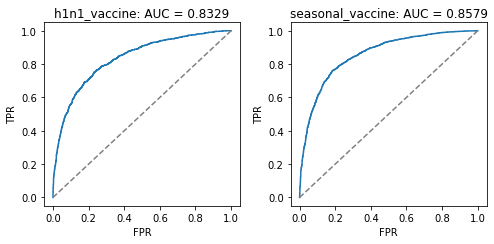

In [4]:
X_eval_ann = preprocessor.transform(X_eval)
preds = model.predict(X_eval_ann)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[:,0],
           "seasonal_vaccine": preds[:,1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

In [66]:
model.save("model_2_PIE_Sequential_ANN.h5")

array([0.1648092 , 0.12368727, 0.03240559, ..., 0.69093835, 0.11387357,
       0.03281251], dtype=float32)

In [48]:
y_train_ann = y_train.copy()
y_train_ann["no_h1n1_vaccine"] = 1 - y_train_ann["h1n1_vaccine"]
y_train_ann["no_seasonal_vaccine"] = 1 - y_train_ann["seasonal_vaccine"]
y_train_ann.head()

,h1n1_vaccine,seasonal_vaccine,no_h1n1_vaccine,no_seasonal_vaccine
respondent_id,,,,
24706,0,0,1,1
5393,0,1,1,0
20898,1,1,0,0
3429,0,0,1,1
8731,0,0,1,1
